## CartPole Skating

> **Problem**: If Peter wants to escape from the wolf, he needs to be able to move faster than him. We will see how Peter can learn to skate, in particular, to keep balance, using Q-Learning.

First, let's install the gym and import required libraries:

In [25]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import random

## Create a cartpole environment

In [26]:
env = gym.make("CartPole-v1")

print(env.action_space)
print(env.observation_space)
print(env.action_space.sample())

Discrete(2)
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
0


To see how the environment works, let's run a short simulation for 100 steps.

In [27]:
env.reset()

for i in range(100):
    env.render()
    env.step(env.action_space.sample())
env.close()

C:\Users\blazr\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\envs\classic_control\cartpole.py:150: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


During simulation, we need to get observations in order to decide how to act. In fact, `step` function returns us back current observations, reward function, and the `done` flag that indicates whether it makes sense to continue the simulation or not:

In [28]:
env.reset()

done = False
while not done:
   env.render()
   obs, rew, done, info = env.step(env.action_space.sample())
   print(f"{obs} -> {rew}")
env.close()

[-0.00951606 -0.16424844 -0.04867884  0.25843555] -> 1.0
[-0.01280103 -0.35864285 -0.04351013  0.53537583] -> 1.0
[-0.01997389 -0.16293696 -0.03280261  0.22930686] -> 1.0
[-0.02323263  0.03263802 -0.02821648 -0.07354002] -> 1.0
[-0.02257987  0.22815289 -0.02968728 -0.37499014] -> 1.0
[-0.01801681  0.03346493 -0.03718708 -0.09181363] -> 1.0
[-0.01734751  0.22909962 -0.03902335 -0.39599326] -> 1.0
[-0.01276552  0.03455244 -0.04694322 -0.11586463] -> 1.0
[-0.01207447  0.23031448 -0.04926051 -0.42298043] -> 1.0
[-0.00746818  0.03592375 -0.05772012 -0.14622478] -> 1.0
[-0.00674971 -0.15832615 -0.06064461  0.12770453] -> 1.0
[-0.00991623 -0.35252926 -0.05809052  0.40065512] -> 1.0
[-0.01696681 -0.5467812  -0.05007742  0.67447245] -> 1.0
[-0.02790244 -0.74117273 -0.03658797  0.9509776 ] -> 1.0
[-0.04272589 -0.9357836  -0.01756842  1.2319442 ] -> 1.0
[-0.06144156 -1.1306753   0.00707047  1.5190717 ] -> 1.0
[-0.08405507 -0.9356395   0.0374519   1.2286041 ] -> 1.0
[-0.10276786 -0.741019    0.062

We can get min and max value of those numbers:

In [29]:
print(env.observation_space.low)
print(env.observation_space.high)

[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


## State Discretization

In [30]:
def discretize(x):
    return tuple((x/np.array([0.25, 0.25, 0.01, 0.1])).astype(int ))

Let's also explore other discretization method using bins:

In [31]:
def create_bins(i, num):
    return np.arange(num+1)*(i[1]-i[0])/num+i[0]

print("Sample bins for interval (-5,5) with 10 bins\n",create_bins((-5,5),10))

ints = [(-5,5),(-2,2),(-0.5,0.5),(-2,2)] # intervals of values for each parameter
nbins = [20,20,10,10] # number of bins for each parameter
bins = [create_bins(ints[i],nbins[i]) for i in range(4)]

def discretize_bins(x):
    return tuple(np.digitize(x[i],bins[i]) for i in range(4))

Sample bins for interval (-5,5) with 10 bins
 [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


Let's now run a short simulation and observe those discrete environment values.

In [32]:
env.reset()

done = False
while not done:
   #env.render()
   obs, rew, done, info = env.step(env.action_space.sample())
   #print(discretize_bins(obs))
   print(discretize(obs))
env.close()

(0, 0, -3, 2)
(0, 0, -3, 0)
(0, 0, -3, 2)
(0, -1, -2, 5)
(0, -2, -1, 8)
(0, -1, 0, 5)
(0, -2, 1, 8)
(0, -1, 2, 5)
(0, -2, 4, 8)
(0, -3, 5, 11)
(0, -2, 8, 8)
(0, -1, 9, 6)
(0, -2, 11, 9)
(0, -3, 12, 12)
(0, -3, 15, 15)
(0, -3, 18, 13)
(0, -2, 21, 11)


## Q-Table Structure

In [33]:
Q = {}
actions = (0, 1)

def qvalues(state):
    return [Q.get((state, a), 0) for a in actions]

## Let's Start Q-Learning!

In [34]:
alpha = 0.3
gamma = 0.9
epsilon = 0.90

In [35]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Qmax = 0
cum_rewards = []
rewards = []
for epoch in range(100000):
    obs = env.reset()
    done = False
    cum_reward=0
    # == do the simulation ==
    while not done:
        s = discretize(obs)
        if random.random()<epsilon:
            # exploitation - chose the action according to Q-Table probabilities
            v = probs(np.array(qvalues(s)))
            a = random.choices(actions,weights=v)[0]
        else:
            # exploration - randomly chose the action
            a = np.random.randint(env.action_space.n)

        obs, rew, done, info = env.step(a)
        cum_reward+=rew
        ns = discretize(obs)
        Q[(s,a)] = (1 - alpha) * Q.get((s,a),0) + alpha * (rew + gamma * max(qvalues(ns)))
    cum_rewards.append(cum_reward)
    rewards.append(cum_reward)
    # == Periodically print results and calculate average reward ==
    if epoch%5000==0:
        print(f"{epoch}: {np.average(cum_rewards)}, alpha={alpha}, epsilon={epsilon}")
        if np.average(cum_rewards) > Qmax:
            Qmax = np.average(cum_rewards)
            Qbest = dict(Q)
        cum_rewards=[]

0: 54.0, alpha=0.3, epsilon=0.9
5000: 81.112, alpha=0.3, epsilon=0.9
10000: 117.9524, alpha=0.3, epsilon=0.9
15000: 132.8202, alpha=0.3, epsilon=0.9
20000: 163.2538, alpha=0.3, epsilon=0.9
25000: 178.4618, alpha=0.3, epsilon=0.9
30000: 195.3468, alpha=0.3, epsilon=0.9
35000: 212.5484, alpha=0.3, epsilon=0.9
40000: 224.0374, alpha=0.3, epsilon=0.9
45000: 225.4388, alpha=0.3, epsilon=0.9
50000: 220.913, alpha=0.3, epsilon=0.9
55000: 240.6086, alpha=0.3, epsilon=0.9
60000: 250.5246, alpha=0.3, epsilon=0.9
65000: 262.8568, alpha=0.3, epsilon=0.9
70000: 268.4128, alpha=0.3, epsilon=0.9
75000: 259.9512, alpha=0.3, epsilon=0.9
80000: 275.0912, alpha=0.3, epsilon=0.9
85000: 280.738, alpha=0.3, epsilon=0.9
90000: 285.7572, alpha=0.3, epsilon=0.9
95000: 289.426, alpha=0.3, epsilon=0.9


## Plotting Training Progress

2927152546944
2927032969984


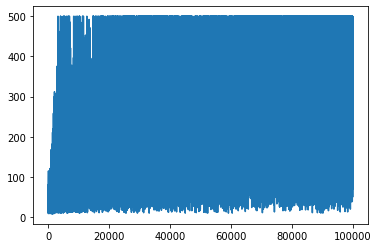

In [40]:
print(id(Qbest))
print(id(Q))

plt.plot(rewards)

From this graph, it is not possible to tell anything, because due to the nature of stochastic training process the length of training sessions varies greatly. To make more sense of this graph, we can calculate **running average** over series of experiments, let's say 100. This can be done conveniently using `np.convolve`:

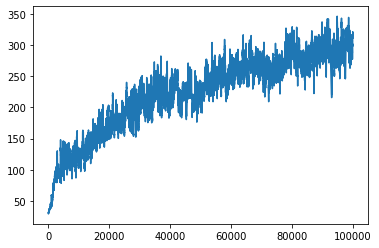

In [41]:
def running_average(x,window):
    return np.convolve(x,np.ones(window)/window,mode='valid')

plt.plot(running_average(rewards,100))

At this point model is quite good, achieving score of 290, whihc is far above required 195:

0: 54.0, alpha=0.3, epsilon=0.9
5000: 81.112, alpha=0.3, epsilon=0.9
10000: 117.9524, alpha=0.3, epsilon=0.9
15000: 132.8202, alpha=0.3, epsilon=0.9
20000: 163.2538, alpha=0.3, epsilon=0.9
25000: 178.4618, alpha=0.3, epsilon=0.9
30000: 195.3468, alpha=0.3, epsilon=0.9
35000: 212.5484, alpha=0.3, epsilon=0.9
40000: 224.0374, alpha=0.3, epsilon=0.9
45000: 225.4388, alpha=0.3, epsilon=0.9
50000: 220.913, alpha=0.3, epsilon=0.9
55000: 240.6086, alpha=0.3, epsilon=0.9
60000: 250.5246, alpha=0.3, epsilon=0.9
65000: 262.8568, alpha=0.3, epsilon=0.9
70000: 268.4128, alpha=0.3, epsilon=0.9
75000: 259.9512, alpha=0.3, epsilon=0.9
80000: 275.0912, alpha=0.3, epsilon=0.9
85000: 280.738, alpha=0.3, epsilon=0.9
90000: 285.7572, alpha=0.3, epsilon=0.9
95000: 289.426, alpha=0.3, epsilon=0.9

## Varying Hyperparameters and Seeing the Result in Action

Now it would be interesting to actually see how the trained model behaves. Let's run the simulation, and we will be following the same action selection strategy as during training: sampling according to the probability distribution in Q-Table: 

In [43]:
obs = env.reset()
done = False
while not done:
   s = discretize(obs)
   env.render()
   v = probs(np.array(qvalues(s)))
   a = random.choices(actions,weights=v)[0]
   obs,_,done,_ = env.step(a)
env.close()

In this case we always select the case with highest qtable value:

In [44]:
obs = env.reset()
done = False
while not done:
   s = discretize(obs)
   env.render()
   v = probs(np.array(qvalues(s)))
   v_max = np.argmax(v)
   a = actions[v_max]
   obs,_,done,_ = env.step(a)
env.close()


## Saving result to an animated GIF

If you want to impress your friends, you may want to send them the animated GIF picture of the balancing pole. To do this, we can invoke `env.render` to produce an image frame, and then save those to animated GIF using PIL library:

In [50]:
from PIL import Image
obs = env.reset()
done = False
i=0
ims = []
while not done:
   s = discretize(obs)
   img=env.render(mode='rgb_array')
   ims.append(Image.fromarray(img))
   v = probs(np.array([Qbest.get((s,a),0) for a in actions]))
   a = random.choices(actions,weights=v)[0]
   obs,_,done,_ = env.step(a)
   i+=1
env.close()
ims[0].save('images/cartpole-balance.gif',save_all=True,append_images=ims[1::2],loop=0,duration=5)
print(i)

276
